In [6]:
#### Keras implementation of NN's which we will look at MNIST with

from __future__ import print_function
import keras as keras 
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.constraints import max_norm
from keras.regularizers import L2
import tensorflow as tf
#import tensorflow_datasets as tfds
import scipy
import h5py
import os
from matplotlib import pyplot as plt
import numpy as np
svhn_path="../Datasets/svhn"#"/Home/Adam/Research/Datasets/svhn"
# Hyper-parameters
K.clear_session() ## needed???
batch_size = 128
num_classes = 10
epochs = 10

img_rows, img_cols = 32, 32

### ???
gpus = tf.config.experimental.list_physical_devices('GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
if gpus:
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  # Restrict TensorFlow to only allocate 2GB of memory on the first GPU
  # I do not know why I have to do this but gpu does not work otherwise.
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
Virtual devices cannot be modified after being initialized


In [7]:
import random
####### label shifting and plotting
plt.rc('font', size=12, family='serif')
#class_label=1
#summand=1
#delta=0.7

## Note: this assumes that you have a one hot encoding and that class_label is within the range of that vector length
def label_shift(X,y,delta,class_label):
    ## takes a dataset and shifts the class label distribution by some margin delta 
    ## we will just give the ``removed'' entries back as the target distribution
    N=len(y)
    idx=[]
    y_2=[]
    X_2=[]
    x_target=[]
    y_target=[]
    for i in range(N):
        if(y[i][class_label]==1):
            idx.append(i)
    ## what proportion of the label to remove
    M=int(len(idx)*delta)
    ## choose randomly delta amount of sample to include in target
    chosen=random.sample(idx,M)
    for i in range(N):
        if(i in chosen):
            x_target.append(X[i])
            y_target.append(y[i])
        else:
            y_2.append(y[i])
            X_2.append(X[i])
    x_target=np.array(x_target)
    y_target=np.array(y_target)
    X_2=np.array(X_2)
    y_2=np.array(y_2)
    return([X_2, y_2, x_target, y_target])

## Note: this assumes that you have a one hot encoding and that class_label is within the range of that vector length
def label_shift_linear(X,y,delta,labels,decreasing=True):
    """
    X: data points
    y: labels
    delta: percentage amount which you want to decrease for each label, i.e. slope for the shifting; delta in [0,1)
    labels: a vector of the possible labels i.e. for MNIST we have labels=[0,1,2,3,4,5,6,7,8,9]
    decreasing: bool to see if you want to make the shift increasing or decreasing
    """
    ## takes a dataset and shifts the class label distribution for all labels by
    ## a linearly increasing or decreasing amount
    ## we will just remove entries of the class for now
    
    L=len(labels)
    y_2=y
    X_2=X
    x_target=[]
    y_target=[]
    ## for every label go through and remove delta*label(or delta*(L-label)) amount of them (+1 to ensure overlap)
    for label in labels:
        if decreasing:
            delta2=delta*(label+1)
        else:
            delta2=delta*(L-label+1)
        assert(delta2<1)
        X_2, y_2, x_target2, y_target2=label_shift(X_2,y_2,delta2,label)
        if (label==0):
            x_target=x_target2
            y_target=y_target2
        else:   
            x_target=np.concatenate((x_target,x_target2))
            y_target=np.concatenate((y_target,y_target2))
        #print("--------------")
        #T=np.array(x_target)
        #print(T.shape)
    return([X_2, y_2, x_target, y_target])

def plot_labeldist(labels,y_1,label_1):
    """
    labels: a vector of the possible labels i.e. for MNIST we have labels=[0,1,2,3,4,5,6,7,8,9]
    y_1: labels of dataset
    label_1: name of dataset
    """
    
    import matplotlib.pyplot as plt


    # calculate the amount of label j in both datasets
    N=len(y_1)
   # M=len(labels)
    densities_1=[]
    sum=0
    for j in labels:
        sum=0
        for i in range(len(y_1)):
            if y_1[i][j]==1:
                sum+=1
        densities_1.append(sum)
       
    densities_1_rel=[]
   
    ## calculate relative density
    for i in range(len(densities_1)):
        densities_1_rel.append(densities_1[i]/(N))
        
    #print(densities_1_rel)


    width = 0.35       # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()

    ax.bar(labels, densities_1_rel, width, label=label_1)
    #ax.set_ylim([0,1.25])
    ax.set_xlabel('Labels')
    ax.set_title('Label distribution')
    ax.legend()
    
    plt.show()
    
def plot_splitbars(labels,y_1,y_2,label_1,label_2):
    """
    labels: a vector of the possible labels i.e. for MNIST we have labels=[0,1,2,3,4,5,6,7,8,9]
    y_1: labels of dataset1
    y_2: labels of dataset2
    label_1: name of dataset1
    label_2: name of dataset2
    """
    
    import matplotlib.pyplot as plt


    # calculate the amount of label j in both datasets
    densities_1=[]
    densities_2=[]
    sum=0
    for j in labels:
        sum=0
        for i in range(len(y_1)):
            if y_1[i][j]==1:
                sum+=1
        densities_1.append(sum)
        sum=0
        for i in range(len(y_2)):
            if y_2[i][j]==1:
                sum+=1
        densities_2.append(sum)
    densities_1_rel=[]
    densities_2_rel=[]
    ## calculate relative densities #### TODO: is this normalisation really what we want?
    for i in range(len(densities_1)):
        densities_1_rel.append(densities_1[i]/(densities_1[i]+densities_2[i]))
        densities_2_rel.append(densities_2[i]/(densities_1[i]+densities_2[i]))
    #print(densities_1_rel)
    #print(densities_2_rel)


    width = 0.35       # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()

    ax.bar(labels, densities_1_rel, width, label=label_1)
    ax.bar(labels, densities_2_rel, width , bottom=densities_1_rel,
           label=label_2)
    ax.set_ylim([0,1.25])
    ax.set_xlabel('Labels')
    ax.set_title('Label distribution')
    ax.legend()
    plt.show()
    

    
######### Here we use the functions above ##############################################################

###### Add train and test together and shift the distributions to create source and target distributions
### MNIST all data
x_full=np.append(x_train,x_test, axis=0)
y_full=np.append(y_train,y_test, axis=0)
### MNIST-M all data
x_full_m=np.append(x_train_m,x_test_m, axis=0)
y_full_m=np.append(y_train_m,y_test_m, axis=0)
#x_shift,y_shift,x_shift_target,y_shift_target =label_shift(x_train,y_train,1/2,7)
x_shift, y_shift, x_shift_target, y_shift_target =label_shift_linear(x_full,y_full,1/12,[0,1,2,3,4,5,6,7,8,9])
x_shift_m, y_shift_m,x_shift_target_m, y_shift_target_m=label_shift_linear(x_full_m,y_full_m,1/12,[0,1,2,3,4,5,6,7,8,9],decreasing=False)
#rint("test of shift")
#print(x_shift_target.shape)
#print(x_shift.shape)
#print(y_shift_target.shape)
#print(y_shift.shape)
plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_shift_target,"shifted, target")
plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_shift,"shifted, source")
plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift,y_shift_m,"MNIST, source","MNIST-M, source")
plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift_target,y_shift_target_m,"MNIST, target","MNIST-M, target")




### TODO: make source and target be the same amount and the proportions more symmetrical across labels if possible 




NameError: name 'x_train' is not defined

In [ ]:
##### Add the label shifted datasets to each other creating the source and target domain for task 2
x_source=np.append(x_shift,x_shift_m, axis=0)
y_source=np.append(y_shift,y_shift_m, axis=0)
x_target=np.append(x_shift_target,x_shift_target_m, axis=0)
y_target=np.append(y_shift_target,y_shift_target_m, axis=0)
#print(x_shift.shape)
#print(x_shift_target.shape)
## sanity check for label distribution, seems ok to me
#plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_full,"MNIST")
#plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_full_m,"MNIST-M")
#plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_source,"MNIST+MNIST-M, source")
#plot_labeldist([0,1,2,3,4,5,6,7,8,9],y_target,"MNIST+MNIST-M, target")


##### make index lists for train and test splits for source

#N=70000 ideally, however, how can we ensure this when the amount differs between labels?
## maybe we do not care too much about it exactly
N=len(y_source)
M=len(x_shift)
train2=[]
train1=[]
test1=[]
test2=[]
ntr1=round(0.8*M)
ntr2=round(0.8*N)
### sample n_tr datapoints (w/o replacement) to be the training set at random
## do this 10 times and save the indices into a file along with the training ones
for i in range(10):
    T=random.sample(range(M),M)
    T2=random.sample(range(N),N)
    train1.append(T[:ntr1])
    train2.append(T2[:ntr2])
    test1.append(T[ntr1:])
    test2.append(T2[ntr2:])

task1=[train1,test1]
task2=[train2,test2]
import pickle
pkl_file=open('splits_task1.pkl','wb')
listoflist=task1
pickle.dump(listoflist,pkl_file)


if True:
    import pickle
    pkl_file=open('splits_task2.pkl','wb')
    listoflist=task2
    pickle.dump(listoflist,pkl_file)
    






In [ ]:
##### load the splits from the file and make the split on the data
import sys
pkl_file=open('splits_task1.pkl','rb')
split1=pickle.load(pkl_file)
pkl_file.close()
traindata=[]
#print(split1[0][0])
for i in split1[0]:
    trainidx=i
    for j in trainidx:
        traindata.append(x_shift[j])
    print(traindata)
    sys.exit(-1)
for j in split1[1]:
    testdata=j

In [2]:
### import svhn_cropped without grayscale

# Open the file as readonly
h5f = h5py.File('SVHN_cropped.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
Y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
Y_test = h5f['y_test'][:]
X_extra = h5f['X_extra'][:]
Y_extra = h5f['y_extra'][:]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_extra = X_extra.astype('float32')

#### make validation set from train and extra (and make extra part of train(?))

X_train=np.append(X_train,X_extra, axis=0)
Y_train=np.append(Y_train,Y_extra, axis=0)
## normalising
sigma=np.std(X_train)
X_train /= sigma 
X_test /= sigma


mu=np.mean(X_train)
X_train -= mu
X_test -= mu





print('mean, variance', mu, sigma)
print("---------------Load SVHN----------------")
print('Training set', X_train.shape, Y_train.shape)
#print('Extra set', X_extra.shape, Y_extra.shape)
print('Test set', X_test.shape, Y_test.shape)

mean, variance 2.1985865 50.549427
---------------Load SVHN----------------
Training set (604388, 32, 32, 3) (604388, 10)
Test set (26032, 32, 32, 3) (26032, 10)


In [ ]:
'''
## import svhn_cropped which is svhn in 32x32 size
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
####### do not load this at the moment!
# Open the file as readonly
h5f = h5py.File('SVHN_gray.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
Y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
Y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
Y_val = h5f['y_val'][:]

# Close this file
h5f.close()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test = x_test.astype('float32')
## normalising
#_train[:,axis=3] /= 255.0 
#X_test /= 255.0
#X_val /= 255.0

print('Training set', X_train.shape, Y_train.shape)
print('Validation set', X_val.shape, Y_val.shape)
print('Test set', X_test.shape, Y_test.shape)
'''

In [8]:
## import mnist
(x_train, lbl_train), (x_test, lbl_test) = mnist.load_data()
x_train = np.pad(x_train,((0,0),(2,2),(2,2))) #padding to make images 32x32 and not 28x28
x_test = np.pad(x_test,((0,0),(2,2),(2,2))) 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## normalising
#x_train /= 255.0 
#x_test /= 255.0

## normalising to unit variance
sigma=np.std(x_train)
x_train /= sigma 
x_test /= sigma

## mean subtraction
mu=np.mean(x_train)
x_train -= mu
x_test -= mu
## make labels into categorical classes
y_train = keras.utils.to_categorical(lbl_train, num_classes)
y_test = keras.utils.to_categorical(lbl_test, num_classes)


x_train=np.expand_dims(x_train,3)
x_test=np.expand_dims(x_test,3)


### make mnist into 3 channels
x_train=np.concatenate((x_train,)*3, axis=-1)
x_test=np.concatenate((x_test,)*3, axis=-1)
print('mean, variance', mu, sigma)
print("---------------Load MNIST----------------")
print('Training set', x_train.shape, y_train.shape)
#print('Validation set', x_val.shape, y_val.shape)
print('Test set', x_test.shape, y_test.shape)


mean, variance 0.36348352 70.18035
---------------Load MNIST----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


In [48]:

### load MNIST-M

#h5f = h5py.File('MNIST-M.h5', 'r')

# Load the training, test and 
#x_train_m = h5f['x_train'][:]
#y_train_m = h5f['y_train'][:]
#x_test_m = h5f['x_test'][:]
#y_test_m = h5f['y_test'][:]
import pandas as pd

# Close this file
#h5f.close()

M = pd.read_pickle('mnistm_data.pkl')
x_train_m =M['train']
x_test_m =M['test']
y_train_m=y_train
y_test_m =y_test
x_train_m = np.pad(x_train_m,((0,0),(2,2),(2,2),(0,0))) #padding to make images 32x32 and not 28x28
x_test_m = np.pad(x_test_m,((0,0),(2,2),(2,2),(0,0)))

x_train_m = x_train_m.astype('float32')
x_test_m = x_test_m.astype('float32')
## normalising to unit variance
sigma=np.std(x_train_m)
x_train_m /= sigma 
x_test_m /= sigma

## mean subtraction
mu=np.mean(x_train_m)
x_train_m -= mu
x_test_m -= mu

print('mean, variance', mu, sigma)
print("---------------Load MNIST-M----------------")
print('Training set', x_train_m.shape, y_train_m.shape)
#print('Validation set', x_val.shape, y_val.shape)
print('Test set', x_test_m.shape, y_test_m.shape)

def make_mnist_binary(y):#### test that this works and can be trained!
    '''
    takes in mnist labels and returns a binarisation
    i.e. 0-4 is 0 and 5-9 is 1 for example
    '''
    
    new_y=[None]*len(y)
    for label in range(len(y)):
        if y[label][0] or y[label][1] or y[label][2] or y[label][3] or y[label][4]:
            new_y[label]=[1, 0]
        else:
            new_y[label]=[0, 1]
    return new_y


mean, variance 1.1809415 74.36859
---------------Load MNIST-M----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0],

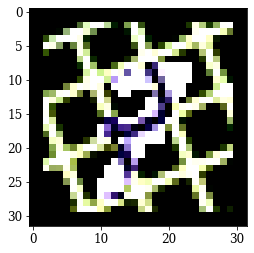

In [47]:
########## preprocessing for mnist and svhn




#print(X_test)
#print("----------------------------------------------------")
#print(x_test)

print(make_mnist_binary(y_train))
plt.imshow(x_test_m[605]) 
#print(x_test_m[303])
print(y_test_m[605])
#plt.imshow(x_test[605]) 
#print(x_test[303])
print(y_test[605])

In [10]:
def nppdist2sq(X,Y):
    """ Computes the squared Euclidean distance between all pairs x in X, y in Y """
    C = -2*np.dot(X,Y.T)
    nx = np.sum(np.square(X),1,keepdims=True)
    ny = np.sum(np.square(Y),1,keepdims=True)
    D = (C + ny.T) + nx
    return D

#print(nppdist2sq(x_train[0],x_train_m[0]))
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y, sigma_sqr=1.0):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

### flatten images into vectors to be able to compute MMD
mnist_flat=[None]*len(x_train)
mnistm_flat=[None]*len(x_train)
for i in range(len(x_train)):
    mnist_flat[i]=tf.reshape(x_train[i],[-1])
    mnistm_flat[i]=tf.reshape(x_train_m[i],[-1])
print(np.array(mnist_flat).shape)
print(np.array(mnistm_flat).shape)
#print(mnistm_flat.shape)


(60000, 3072)
(60000, 3072)


In [66]:
#print(nppdist2sq(np.array(mnist_flat[:800]),np.array(mnistm_flat[:800])))

#print(compute_mmd(np.array(mnist_flat[:200]),np.array(mnistm_flat[:200])))
#print(np.array(mnistm_flat[1:][::2]).shape)
#print(np.array(mnistm_flat[::2]))
import math
def mmd_linear(x,y,sigma_square):
    """
    Here we want to compute the unbiased estimate of the MMD using the formula
    MMD^2_k(p,q)=2/n_s for i=1 to n_s/2 g_k(z_i)
    ,where z_i=(x^s_2i-1,x^s_2i,x^t_2i-1,x^t_2i) and
    g_k(z_i)= k(x^s_2i-1,x^s_2i)+k(x^t_2i-1,x^t_2i)-k(x^s_2i-1,x^t_2i)-k(x^s_2i,x^t_2i-1)
    """
    
    
    ##take out odd and even entries for the two vectors
    x_even=x[::2]
    x_odd=x[1:][::2]
    y_even=y[::2]
    y_odd=y[1:][::2]
  #  print(x_odd)
  #  print(x_even)
    n_s=len(x)
    
    mmd=0
    for i in range(round(n_s/2.0)):
        ### sum the kernels for the chosen pairs
        mmd+=kernel(x_even[i],x_odd[i],sigma_square)
        mmd+=kernel(y_even[i],y_odd[i],sigma_square)
        mmd-=kernel(x_even[i],y_odd[i],sigma_square)
        mmd-=kernel(y_even[i],x_odd[i],sigma_square)
    mmd=mmd*(2/n_s)
    return mmd
def kernel(x,y,sigma_square):
    return np.exp(-np.sum(np.square(x-y))/(2*sigma_square))#*1/(np.sqrt(2*math.pi*sigma_square))
#print(kernel(np.array(mnist_flat[0]),np.array(mnistm_flat[0])))
#mmd_linear(mnist_flat,mnistm_flat)
##### do this for a range of sigma and sum the results for an estimation of the true MMD

sigmas = [
      1e-6, 1e-5, 
      1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
      1e3, 1e4, 1e5, 1e6
  ]
test=[1e-5]
mmdlist=[]
#print(mnist_flat[1])
#print(mnistm_flat[1])

#### generate data from two gaussian distributions with different mean and compute mmd?
#x=[1,2,3,4]
#y=[4,4,4,4]
#print(mmd_linear(x,y,1e5))
#for sigma in sigmas:
    #mmdlist.append(mmd_linear(mnist_flat,mnistm_flat,sigma))
#print(mmdlist)
#finalmmd=np.sqrt(np.sum(mmdlist))
#print(finalmmd)
#### test with normal dist

MMD=[]
for i in range(1000):
    samples = np.random.normal(0, 1, 1000);
    samples2= np.random.normal(5, 1, 1000);
    mmds=[]
    for sigma in sigmas:
        mmds.append(mmd_linear(samples,samples2,sigma))
    
    MMD.append(np.sqrt(np.sum(mmds)))
print("-------------------------------------------------------------")
print(MMD)
print(np.mean(MMD))
### mnist vs mnistm: 0.5367568640253743

### label shift:

#### gaussians N(0,1) vs N(5,1): 2.88
def weight_diff(w1, w2):
    """ Calculates the array of differences between the weights in arrays """
    # Expand and flatten arrays
    _w1 = np.hstack([x.flatten() for x in w1])
    _w2 = np.hstack([x.flatten() for x in w2])
    return _w1 - _w2
                 
def l2_norm(w1, w2):
    return np.linalg.norm(weight_diff(w1, w2))        
        
def estimate_KL(posterior_weights,prior_weights,sigma):
    """
    provides an estimate of the KL-div between prior and posterior
    
    We assume that we have a multivariate gaussian centred at the the weights for the prior and posterior.
    We also assume that the variance of the prior is isotropic gaussian and also that it is the same in the prior.
    """
    KL=l2_norm(posterior_weights,prior_weights)**2
    KL=KL/(2*sigma)
    return KL
#estimate_KL(samples,samples2,1)
#### KL with N(0,1) vs N(5,1): ~13000 expected 12500 on average so seems about right
#l2_norm(samples,samples2)

-------------------------------------------------------------
[2.8742739146408067, 2.9141921741737926, 2.8698280219265433, 2.881895083735111, 2.872765999960552, 2.8856510194467653, 2.8691216671142046, 2.9012728819130267, 2.8874787915661155, 2.8677789223659396, 2.8602175148446674, 2.8623596419409125, 2.886766510882054, 2.902916145463848, 2.898520296753191, 2.917369818312781, 2.91520209978916, 2.8847459270998823, 2.8647514294645604, 2.8454817132125805, 2.894103561231321, 2.878586604299674, 2.9002608999753883, 2.887192692483861, 2.9105035202741774, 2.890507338762218, 2.9122700785442484, 2.8883890795400182, 2.884876471988092, 2.8966518780819257, 2.869417495207906, 2.838844732462578, 2.835053587169165, 2.87074553451585, 2.8676033794302596, 2.8916687229635016, 2.8875301802073507, 2.8932010390346417, 2.8707259019116473, 2.9059917234807986, 2.9044140619816954, 2.8839462359510843, 2.859386970101817, 2.877035345561989, 2.8759869748228435, 2.931466543071541, 2.889781231879194, 2.8843765139670845,

In [12]:
## implement LeNet-5 architecture
def init_model():
    model = Sequential()
    model.add(Conv2D(6,(5,5),strides=(1,1), activation='tanh',input_shape=(32,32,1))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(16,(5,5),strides=(1,1), activation='tanh')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    model.add(Flatten())
    #model.add(Dense(120, activation='tanh'))  #equivalent to the last conv2d above?
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

In [13]:
## implement LeNet-5-like architecture
def init_SVHN_model():
    model = Sequential()
    model.add(Conv2D(64,(5,5),strides=(1,1), activation='relu',input_shape=(32,32,3),kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005))) ## 6 5x5 conv kernels
    model.add(Dropout(0.9))
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(64,(5,5),strides=(1,1), activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005))) ## 16 5x5 conv kernels
    model.add(Dropout(0.75))
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(128,(5,5),strides=(1,1), activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005)))
    model.add(Dropout(0.75))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(3072, activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005)))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax',kernel_constraint=max_norm(4), bias_constraint=max_norm(4),kernel_regularizer=L2(0.0005), bias_regularizer=L2(0.0005))) # output layer
    
    return model

'''
We use stochastic gradient descent with
momentum: 0.9
weight_decay: 0.0005
------ this was not used on mnist<->svhn tests
and the learning rate annealing described by the following formula:
µp =µ0/(1 + α · p)^β,
where p is the training progress linearly changing from 0
to 1, µ0 = 0.01, α = 10 and β = 0.75 (the schedule
was optimized to promote convergence and low error on
the source domain).
------

Following (Srivastava et al., 2014) we also use dropout and
l_2-norm restriction when we train the SVHN architecture.
'''

'\nWe use stochastic gradient descent with\nmomentum: 0.9\nweight_decay: 0.0005\n------ this was not used on mnist<->svhn tests\nand the learning rate annealing described by the following formula:\nµp =µ0/(1 + α · p)^β,\nwhere p is the training progress linearly changing from 0\nto 1, µ0 = 0.01, α = 10 and β = 0.75 (the schedule\nwas optimized to promote convergence and low error on\nthe source domain).\n------\n\nFollowing (Srivastava et al., 2014) we also use dropout and\nl_2-norm restriction when we train the SVHN architecture.\n'

In [14]:
## implement LeNet-5-like architecture
def init_MNIST_model():
    model = Sequential()
    model.add(Conv2D(32,(5,5),strides=(1,1), activation='relu',input_shape=(32,32,3))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Conv2D(48,(5,5),strides=(1,1), activation='relu')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

In [15]:
## shamelessly taken from : https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras

## Custom callback to be able to evaluate and save the results from several validation sets during training
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [2, 3]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for i, result in enumerate(results):
                
                if i == 0:
                    valuename = validation_set_name + '_loss'
                else:
                    valuename = validation_set_name + '_' + self.model.metrics[i].name
                self.history.setdefault(valuename, []).append(result)

In [16]:
def train_model(model="SVHN" ,batch_size=128 ,total_epochs=25 ,iterations=1 ,x_train=[] ,y_train=[] ,x_test=[] ,y_test=[] ,x_target=[] ,y_target=[]):
    history = AdditionalValidationSets([(x_target, y_target, 'target_val')])
    
    # Include the epoch in the file name (uses `str.format`)
    checkpoint_path = "checkpoints/"+model+"-cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights every 5 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
        ## tune when to save as needed for plots
    save_freq=10*235    ### 469 = ceiling(60000/128) i.e training set for MNIST/MNIST-M
    )
    
    histories=[]
    M=init_SVHN_model()
    for i in range(iterations):
        if model=="SVHN":
            M=init_SVHN_model()
        elif model=="MNIST":
            M=init_MNIST_model()
        elif model=="MNIST-M":
            M=init_MNIST_model()
        elif model=="2MNIST-M":
            M=init_MNIST_model()
        # Save the weights using the `checkpoint_path` format
        M.save_weights(checkpoint_path.format(epoch=0))
        ## choose loss function, optimiser etc. and train
        M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                      metrics=['accuracy'],)

        fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(x_test, y_test),
           callbacks=[history,cp_callback])
        histories.append(history.history)
    return histories

In [17]:
def plot_results(total_epochs,model="SVHN",result=[], xlabel="Epoch",save=True):#,ylabel="", title=""): 
    ### TODO: do one for each type of plot?
    
    from datetime import datetime

    # datetime object containing current date and time
    now = datetime.now()

    # dd/mm/YY_H:M
    dt_string = now.strftime("%d%m%Y_%H:%M")
    #print("date and time =", dt_string)
    
    ## plotting and saving to disk
    x=[i+1 for i in range(total_epochs)]

    if model=="SVHN":
        prefix=["S2MTGTACC","S2MVAL","S2MLOSS","S2MVALLOSS","S2MTGTLOSS"]
    elif model=="MNIST":
        prefix=["M2STGTACC","M2SVAL","M2SLOSS","M2SVALLOSS","M2STGTLOSS"]
    elif model=="MNIST-M":
         prefix=["MM2MTGTACC","MM2MVAL","MM2MLOSS","MM2MVALLOSS","MM2MTGTLOSS"]
    elif model=="2MNIST-M":
        prefix=["M2MMTGTACC","M2MMVAL","M2MMLOSS","M2MMVALLOSS","M2MMTGTLOSS"]

    f, ax = plt.subplots()
    ax.plot(x,result['target_val_accuracy'], '*-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Target acc'], loc = 0)
    ax.set_title('Target acc per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    if(save):
        f.savefig("./images/"+prefix[0]+dt_string+".pdf")
   

    f, ax = plt.subplots()
    ax.plot(x,result['val_accuracy'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Validation acc per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    if(save):
        f.savefig("./images/"+prefix[1]+dt_string+".pdf")

    f, ax = plt.subplots()
    
    ax.plot(x,result['loss'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Training loss'], loc = 0)
    ax.set_title('Training loss per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/"+prefix[2]+dt_string+".pdf")

    f, ax = plt.subplots()
    ax.plot(x,result['val_loss'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Validation loss'], loc = 0)
    ax.set_title('Validation loss per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/"+prefix[3]+dt_string+".pdf")
    
    f, ax = plt.subplots()
    ax.plot(x,result['target_val_loss'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Target acc'], loc = 0)
    ax.set_title('Target loss per epoch')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/"+prefix[4]+dt_string+".pdf")

In [18]:
def plot_results_data(sizes=[],model="SVHN",result=[],save=True):# plot for the increasing amount of data
    ### TODO: do one for each type of plot?
    
    from datetime import datetime

    # datetime object containing current date and time
    now = datetime.now()

    # dd/mm/YY_H:M
    dt_string = now.strftime("%d%m%Y_%H:%M")
    #print("date and time =", dt_string)
    
    ## plotting and saving to disk
    x=[i+1 for i in range(total_epochs)]

    if model=="SVHN":
        prefix=["S2MTGTACC","S2MVAL","S2MVALLOSS","S2MTGTLOSS"]
        target="MNIST"
    elif model=="MNIST":
        prefix=["M2STGTACC","M2SVAL","M2SVALLOSS","M2STGTLOSS"]
        target="SVHN"
    elif model=="MNIST-M":
         prefix=["MM2MTGTACC","MM2MSRCACC","MM2MSRCLOSS","MM2MTGTLOSS"]
    elif model=="2MNIST-M":
        prefix=["M2MMTGTACC","M2MMVAL","M2MMLOSS","M2MMVALLOSS","M2MMTGTLOSS"]
    
    f, ax = plt.subplots()
    ax.plot(sizes,aggregate_acc_t, '*-')
    # Plot legend and use the best location automatically: loc = 0.
    #ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
    ax.legend(['Target acc'], loc = 0)
    #ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Target acc per amount of training data ('+model+'->'+target+')')
    #ax.set_title('Validation acc per epoch')
    ax.set_xlabel('Data amount')
    ax.set_ylabel('Accuracy')
    if(save):
        f.savefig("./images/data/"+prefix[0]+dt_string+".pdf")

    f, ax = plt.subplots()
    #ax.plot(x,result['accuracy'], 'o-')
    #ax.plot(x,result['val_accuracy'], 'x-')
    ax.plot(sizes,aggregate_acc_s, '*-')
    # Plot legend and use the best location automatically: loc = 0.
    #ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
    ax.legend(['Source acc'], loc = 0)
    #ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Source acc per amount of training data ('+model+'->'+target+')')
    #ax.set_title('Validation acc per epoch')
    ax.set_xlabel('Data amount')
    ax.set_ylabel('Accuracy')
    if(save):
        f.savefig("./images/data/"+prefix[1]+dt_string+".pdf")

    f, ax = plt.subplots()
    #ax.plot(x,result['accuracy'], 'o-')
    #ax.plot(x,result['val_accuracy'], 'x-')
    ax.plot(sizes,aggregate_loss_s, '*-')
    # Plot legend and use the best location automatically: loc = 0.
    #ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
    ax.legend(['Source loss'], loc = 0)
    #ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Source loss per amount of training data ('+model+'->'+target+')')
    #ax.set_title('Validation acc per epoch')
    ax.set_xlabel('Data amount')
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/data/"+prefix[2]+dt_string+".pdf")
    
    f, ax = plt.subplots()
    #ax.plot(x,result['accuracy'], 'o-')
    #ax.plot(x,result['val_accuracy'], 'x-')
    ax.plot(sizes,aggregate_loss_t, '*-')
    # Plot legend and use the best location automatically: loc = 0.
    #ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
    ax.legend(['Target loss'], loc = 0)
    #ax.legend(['Validation acc'], loc = 0)
    ax.set_title('Target loss per amount of training data ('+model+'->'+target+')')
    #ax.set_title('Validation acc per epoch')
    ax.set_xlabel('Data amount')
    ax.set_ylabel('Loss')
    if(save):
        f.savefig("./images/data/"+prefix[3]+dt_string+".pdf")

In [ ]:
'''### test for SVHN-> MNIST, 
total_epochs=220 #


iterations=10
histories=[]

#histories=train_model(model="SVHN",total_epochs=total_epochs,iterations=iterations,x_train=X_train,y_train=Y_train,x_test=X_test,y_test=Y_test,x_target=x_test,y_target=y_test)
    
histories=train_model(total_epochs=total_epochs,x_train=X_train,y_train=Y_train,x_test=X_test,y_test=Y_test,x_target=x_test,y_target=y_test)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="SVHN",result=result,xlabel="Epoch",total_epochs=total_epochs)
'''

In [ ]:
'''### test for MNIST->SVHN
total_epochs=2000 #


iterations=10
histories=[]


    
histories=train_model(model="MNIST",total_epochs=total_epochs,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,x_target=X_test,y_target=Y_test)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="MNIST",result=result,xlabel="Epoch",total_epochs=total_epochs)
'''

In [ ]:
'''### test for MNIST-M-> MNIST
total_epochs=2000 #


iterations=10
histories=[]


    
histories=train_model(model="MNIST-M",total_epochs=total_epochs,x_train=x_train_m,y_train=y_train_m,x_test=x_test_m,y_test=y_test_m,x_target=x_test,y_target=y_test)
   
                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="MNIST-M",result=result,xlabel="Epoch",total_epochs=total_epochs)
'''

In [ ]:
#test for MNIST-> MNIST-M
total_epochs=200 #


iterations=1
histories=[]



histories=train_model(model="2MNIST-M",total_epochs=total_epochs,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test,x_target=x_test_m,y_target=y_test_m)


                      
##### Aggregating over all the training runs                    
K=histories[0].keys()
                
result={}
for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)

    
## plotting and saving to disk
plot_results(model="2MNIST-M",result=result,xlabel="Epoch",total_epochs=total_epochs,save=False)


In [ ]:
from keras import backend as K
## taken from springerNLP github
# https://github.com/SpringerNLP/Chapter11/blob/master/maximum_mean_discrepancy.py

def expand_multiple_dims(x, axes, name="expand_multiple_dims"):
  """
  :param tf.Tensor x:
  :param list[int]|tuple[int] axes: after completion, tf.shape(y)[axis] == 1 for axis in axes
  :param str name: scope name
  :return: y where we have a new broadcast axis for each axis in axes
  :rtype: tf.Tensor
  """
  with tf.name_scope(name):
    for i in sorted(axes):
      x = tf.expand_dims(x, axis=i, name="expand_axis_%i" % i)
    return x


def dimshuffle(x, axes, name="dimshuffle"):
  """
  Like Theanos dimshuffle.
  Combines tf.transpose, tf.expand_dims and tf.squeeze.

  :param tf.Tensor x:
  :param list[int|str]|tuple[int|str] axes:
  :param str name: scope name
  :rtype: tf.Tensor
  """
  with tf.name_scope(name):
    assert all([i == "x" or isinstance(i, int) for i in axes])
    real_axes = [i for i in axes if isinstance(i, int)]
    bc_axes = [i for (i, j) in enumerate(axes) if j == "x"]
    if x.get_shape().ndims is None:
      x_shape = tf.shape(x)
      x = tf.reshape(x, [x_shape[i] for i in range(max(real_axes) + 1)])  # will have static ndims
    assert x.get_shape().ndims is not None

    # First squeeze missing axes.
    i = 0
    while i < x.get_shape().ndims:
      if i not in real_axes:
        x = tf.squeeze(x, axis=i)
        real_axes = [(j if (j < i) else (j - 1)) for j in real_axes]
      else:
        i += 1

    # Now permute.
    assert list(sorted(real_axes)) == list(range(x.get_shape().ndims))
    if real_axes != list(range(x.get_shape().ndims)):
      x = tf.transpose(x, real_axes)

    # Now add broadcast dimensions.
    if bc_axes:
      x = expand_multiple_dims(x, bc_axes)
    assert len(axes) == x.get_shape().ndims
    return x

def mmd(x1, x2, beta):
    """
    maximum mean discrepancy (MMD) based on Gaussian kernel
    function for keras models (theano or tensorflow backend)
    
    - Gretton, Arthur, et al. "A kernel method for the two-sample-problem."
    Advances in neural information processing systems. 2007.
    """
    x1x1 = gaussian_kernel(x1, x1, beta)
    x1x2 = gaussian_kernel(x1, x2, beta)
    x2x2 = gaussian_kernel(x2, x2, beta)
    diff = x1x1.mean() - 2 * x1x2.mean() + x2x2.mean()
    return diff

def gaussian_kernel(x1, x2, beta = 1.0):
    #r = tf.transpose(x1)
    #r = x.dimshuffle(0,'x',1)
    return K.exp( -beta * K.square(x1 - x2).sum(axis=-1))

print(mmd(x_train,x_test,1))

In [55]:
### train and get the prior as in Dziugaite

## train from random initialisation on an alpha large partition of the data

def train_prior_and_posterior(alpha,x_train,y_train,x_test,y_test,b=256,sigma=1e3):
    
    
    """
    alpha is the proportion of the training data used for the prior 
    
    b is the batch size, 256 in Dziugaite
    
    """
    from sklearn.model_selection import train_test_split
    
    x_bound, x_prior, y_bound , y_prior = train_test_split(x_train,y_train,test_size=alpha)
    
    N=len(x_prior)
    
    w_a=train_prior(alpha,total_epochs=round(N/b),x_train=x_prior,y_train=y_prior)
    
    #### train posterior until some error/loss has been achieved, then terminate
    w_s, train_acc=train_posterior(alpha,w_a,x_train,y_train,x_test,y_test)
    
  
    
    ## should we return anything?
    return w_a,w_s,N,train_acc
def calculate_bound(w_a,w_s,sigma,delta,N,train_error):
    KL=estimate_KL(w_s,w_a,sigma)
    print(KL)
    B=(KL+np.log(2*np.sqrt(N)/delta))/N
    print(B)
    ## quad bound
    bound=np.min([train_error+np.sqrt(B/2),train_error+B+np.sqrt(B*(B+2*train_error))])
    return bound
def train_prior(alpha,total_epochs,x_train=[],y_train=[],x_test=[],y_test=[],save=True):
    # Include the epoch in the file name (uses `str.format`)
    checkpoint_path = "priors/"+str(alpha)+"prior.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    M=init_MNIST_model()

        ## choose loss function, optimiser etc. and train
    M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
    fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
                        )
    #### save the prior weights to disk
    if save:
        M.save_weights(checkpoint_path)
        
    return M.get_weights()
def train_posterior(alpha,prior_weights,x_train,y_train,x_test,y_test,save=True):
        """
        takes the prior weights, if any, and trains so we get a posterior.
        """
        # Include the epoch in the file name (uses `str.format`)
        checkpoint_path = "posteriors/"+str(alpha)+"{epoch:04d}.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        # Create a callback that saves the model's weights every 50 epochs
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
            ## tune when to save as needed for plots
        save_freq=10*235    ### 469 = ceiling(60000/128) i.e training set for MNIST/MNIST-M
        )
    
        M=init_MNIST_model()
        ### load the prior weights
        M.set_weights(prior_weights)
        ## choose loss function, optimiser etc. and train
        M.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
        #callback=tf.keras.callbacks.EarlyStopping(monitor='accuracy',baseline=0.99)
        fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=20, # we should have early stopping here instead of this I think
           callbacks=[cp_callback],
           validation_data=(x_test, y_test),
           verbose=1,
                        )
         #### save the posterior weights to disk
        if save:
            M.save_weights(checkpoint_path.format(epoch=9999))
        W=M.get_weights()
        return W, fit_info.history['val_accuracy'] ## should it be accuracy on train here? 
def weight_diff(w1, w2):
    """ Calculates the array of differences between the weights in arrays """
    # Expand and flatten arrays
    _w1 = np.hstack([x.flatten() for x in w1])
    _w2 = np.hstack([x.flatten() for x in w2])
    return _w1 - _w2
                 
def l2_norm(w1, w2):
    return np.linalg.norm(weight_diff(w1, w2))        
        
def estimate_KL(posterior_weights,prior_weights,sigma):
    """
    provides an estimate of the KL-div between prior and posterior
    
    We assume that we have a multivariate gaussian centred at the the weights for the prior and posterior.
    We also assume that the variance of the prior is isotropic gaussian and also that it is the same in the prior.
    """
    KL=l2_norm(posterior_weights,prior_weights)**2
    KL=KL/(2*sigma)
    return KL




###### do a function which reads in weights and such and then calculates the actual bound
###### maybe also plots the bound, 
delta=0.05 ## what would this be?     
w_s,w_a,N,train_acc=train_prior_and_posterior(0.1,x_train,y_train,x_test,y_test)
bound=[]
for acc in train_acc:
    train_error=1-acc
    
    bound.append(1-calculate_bound(w_a,w_s,sigma,delta,N,train_error))
print(train_acc)
print(bound)
plt.plot(train_acc)
plt.plot(bound)
plt.show()

#### load in the weights from directory
## take all files which have ckpt-data in them and load if that works
## otherwise make the loop over the known names since we can choose directory and filenames
errors=[]
for file in directory:
    M=init_MNIST_model()
    M.load_weights(file)
    #### evaluate network error 
    errors.append(M.evaluate(x_train, y_train, verbose = 0))
    #### calculate KL from loaded weights and prior weights
#### calculate bound


NameError: name 'init_MNIST_model' is not defined

In [ ]:
'''
### test for SVHN-> MNIST,  USING only a part of the training set
total_epochs=200 #

from sklearn.model_selection import train_test_split
num_runs=1
iterations=1
histories=[]
prev_loss_t=[]
prev_loss_s=[]
prev_acc_t=[]
prev_acc_s=[]
N=len(X_train)

for runs in range(num_runs):
    target_acc=[]
    target_loss=[]
    source_acc=[]
    source_loss=[]
    sizes=[]
    
    for i in range(iterations):
        
        size=round(0.001*N)*(10*i+1)
        
        sizes.append(size)
         ## take out 1*i percent of the data and train
        X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train,Y_train,test_size=size)
        histories=train_model(total_epochs=total_epochs,x_train=X_test2,y_train=Y_test2,x_test=X_test,y_test=Y_test,x_target=x_test,y_target=y_test)
        
        # get last epochs accuracy for target
        target_acc.append(histories[0]['target_val_accuracy'][-1])
        target_loss.append(histories[0]['target_val_loss'][-1])
        source_acc.append(histories[0]['val_accuracy'][-1])
        source_loss.append(histories[0]['val_loss'][-1])
    
    ##### append the list of last epoch accuracies for each amount of data                    
    ##### to the prev_runs list
    print(target_acc)
    prev_loss_t.append(target_loss)
    prev_loss_s.append(source_loss)
    prev_acc_t.append(target_acc)
    prev_acc_s.append(source_acc)
    

### take mean over all runs

aggregate_loss_t=np.mean(prev_loss_t,axis=0)
aggregate_loss_s=np.mean(prev_loss_s,axis=0)
aggregate_acc_t=np.mean(prev_acc_t,axis=0)
aggregate_acc_s=np.mean(prev_acc_s,axis=0)

result=[]
result.append(aggregate_acc_t)
result.append(aggregate_acc_s)
result.append(aggregate_loss_s)
result.append(aggregate_loss_t)

    
## plotting and saving to disk
plot_results_data(sizes=sizes,result=result,save=False)
'''

In [ ]:
 '''
    ### test for MNIST->SVHN,  USING only a part of the training set
total_epochs=200 #

from sklearn.model_selection import train_test_split
num_runs=5
iterations=15
histories=[]
prev_loss_t=[]
prev_loss_s=[]
prev_acc_t=[]
prev_acc_s=[]
N=len(X_train)

for runs in range(num_runs):
    target_acc=[]
    target_loss=[]
    source_acc=[]
    source_loss=[]
    sizes=[]
    
    for i in range(iterations):
        
        size=round(0.001*N)*(10*i+1)
        
        sizes.append(size)
         ## take out 1*i percent of the data and train
        x_train2, x_test2, y_train2, y_test2 = train_test_split(x_train,y_train,test_size=size)
        histories=train_model(model='MNIST',total_epochs=total_epochs,x_train=x_test2,y_train=y_test2,x_test=x_test,y_test=y_test,x_target=X_test,y_target=Y_test)
        
        # get last epochs accuracy for target
        target_acc.append(histories[0]['target_val_accuracy'][-1])
        target_loss.append(histories[0]['target_val_loss'][-1])
        source_acc.append(histories[0]['val_accuracy'][-1])
        source_loss.append(histories[0]['val_loss'][-1])
    
    ##### append the list of last epoch accuracies for each amount of data                    
    ##### to the prev_runs list
    print(target_acc)
    prev_loss_t.append(target_loss)
    prev_loss_s.append(source_loss)
    prev_acc_t.append(target_acc)
    prev_acc_s.append(source_acc)
    

### take mean over all runs

aggregate_loss_t=np.mean(prev_loss_t,axis=0)
aggregate_loss_s=np.mean(prev_loss_s,axis=0)
aggregate_acc_t=np.mean(prev_acc_t,axis=0)
aggregate_acc_s=np.mean(prev_acc_s,axis=0)

result=[]
result.append(aggregate_acc_t)
result.append(aggregate_acc_s)
result.append(aggregate_loss_s)
result.append(aggregate_loss_t)

    
## plotting and saving to disk
plot_results_data(model='MNIST',sizes=sizes,result=result)
    
    
'''

In [ ]:
    '''
    ######## PLOTS for MNIST ############
f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
#ax.plot(x,result['val_accuracy'], 'x-')
ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (MNIST->SVHN)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNISTval.pdf")


f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
ax.plot(x,result['val_accuracy'], 'x-')
#ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (MNIST->SVHN)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNIST2SVHNval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Training loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("MNIST2SVHNloss.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("MNIST2SVHNvalloss.pdf")


############SVHN PLOTS ############ 

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
#ax.plot(x,result2['val_accuracy'], 'x-')
ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (SVHN->MNIST)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_accuracy'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Training loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTloss.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_loss'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation loss per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTvalloss.pdf")
'''